                                        Front Image  \
0  /home/admin/logging/image_data/image_front_1.jpg   
1  /home/admin/logging/image_data/image_front_2.jpg   
2  /home/admin/logging/image_data/image_front_3.jpg   
3  /home/admin/logging/image_data/image_front_4.jpg   
4  /home/admin/logging/image_data/image_front_5.jpg   

                                        Left Image  \
0  /home/admin/logging/image_data/image_left_1.jpg   
1  /home/admin/logging/image_data/image_left_2.jpg   
2  /home/admin/logging/image_data/image_left_3.jpg   
3  /home/admin/logging/image_data/image_left_4.jpg   
4  /home/admin/logging/image_data/image_left_5.jpg   

                                        Right Image  Steering Angle  
0  /home/admin/logging/image_data/image_right_1.jpg       -0.547284  
1  /home/admin/logging/image_data/image_right_2.jpg       -0.547284  
2  /home/admin/logging/image_data/image_right_3.jpg       -0.547284  
3  /home/admin/logging/image_data/image_right_4.jpg       -0.547

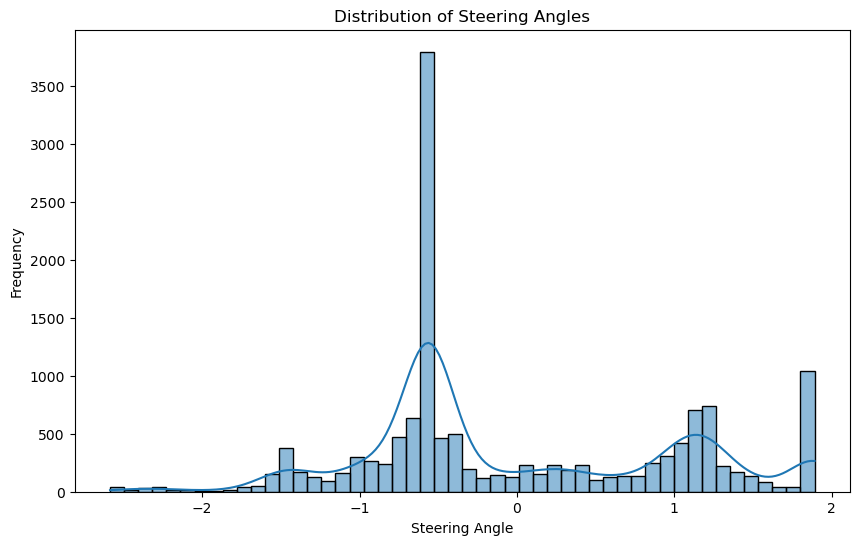

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Load your data
data_dir = r"C:\Users\User\OneDrive\Desktop\AV Lab\logging_weird_2\logging"
log_file_path = os.path.join(data_dir, "logging_data", "log_file_0.txt")
image_base_path = os.path.join(data_dir, "image_data")

# Read the log file content
with open(log_file_path, 'r') as file:
    log_file_content = file.read()

# Process the log file content
log_lines = log_file_content.strip().split('\n')
data = []
for line in log_lines:
    parts = line.split()
    if len(parts) == 5 and parts[0] != 'Time':
        front_image, left_image, right_image, steering_angle = parts[1:5]
        data.append([front_image, left_image, right_image, float(steering_angle)])

# Create a pandas DataFrame
df = pd.DataFrame(data, columns=['Front Image', 'Left Image', 'Right Image', 'Steering Angle'])


steering_angles = df['Steering Angle'].values  

# Normalization (to [-1, 1])
scaler = MinMaxScaler(feature_range=(-1, 1))
steering_angles = scaler.fit_transform(steering_angles.reshape(-1, 1))

# Standardization (Z-score scaling)
standardizer = StandardScaler()
steering_angles = standardizer.fit_transform(steering_angles)

# Update the DataFrame
df['Steering Angle'] = steering_angles

print(df.head())

# Plot the distribution of the "Steering Angle" column
plt.figure(figsize=(10, 6))
sns.histplot(df['Steering Angle'], bins=50, kde=True)  
plt.title('Distribution of Steering Angles')
plt.xlabel('Steering Angle')
plt.ylabel('Frequency')
plt.show()


# Balancing the Dataset by Oversampling Extreme Steering Angles:

In [5]:
def oversample_extreme_angles(dataframe, steering_column='Steering Angle', lower_quantile=0.05, upper_quantile=0.95):
    lower_threshold = dataframe[steering_column].quantile(lower_quantile)
    upper_threshold = dataframe[steering_column].quantile(upper_quantile)
    
    normal_df = dataframe[(dataframe[steering_column] >= lower_threshold) & (dataframe[steering_column] <= upper_threshold)]
    extreme_df = dataframe[(dataframe[steering_column] < lower_threshold) | (dataframe[steering_column] > upper_threshold)]
    
    oversampled_extreme_df = extreme_df.sample(len(normal_df), replace=True)
    
    balanced_df = pd.concat([normal_df, oversampled_extreme_df]).sample(frac=1).reset_index(drop=True)
    
    return balanced_df

# Apply the oversampling
df_balanced = oversample_extreme_angles(df)
train_df, valid_df = train_test_split(df_balanced, test_size=0.2, random_state=42)


# Image Preprocessing and Augmentation

In [7]:
import cv2
from imgaug import augmenters as iaa

def img_preprocess(img):
    img = img[200:450, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img / 255.0
    return img

def random_augment(image, steering_angle):
    if np.random.rand() < 0.5:
        image = iaa.Affine(scale=(1, 1.3)).augment_image(image)
    if np.random.rand() < 0.5:
        image = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}).augment_image(image)
    if np.random.rand() < 0.5:
        image = iaa.Multiply((0.2, 1.2)).augment_image(image)
    if np.random.rand() < 0.5:
        image, steering_angle = cv2.flip(image, 1), -steering_angle
    return image, steering_angle


# Focal Loss

In [9]:
import torch
import torch.nn as nn

class FocalLossRegression(nn.Module):
    def __init__(self, gamma=1.0, alpha=0.1, reduction='mean'):
        super(FocalLossRegression, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, predictions, targets):
        mse_loss = (predictions - targets) ** 2
        modulating_factor = torch.abs(predictions - targets) ** self.gamma
        focal_loss = self.alpha * modulating_factor * mse_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class AlphaScheduler:
    def __init__(self, focal_loss, initial_alpha=0.1, factor=0.5, patience=5, min_alpha=0.01):
        self.focal_loss = focal_loss
        self.alpha = initial_alpha
        self.factor = factor
        self.patience = patience
        self.min_alpha = min_alpha
        self.best_loss = float('inf')
        self.num_bad_epochs = 0
    
    def step(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.num_bad_epochs = 0
        else:
            self.num_bad_epochs += 1
        
        if self.num_bad_epochs >= self.patience:
            self.alpha = max(self.alpha * self.factor, self.min_alpha)
            self.num_bad_epochs = 0
            print(f"Reduced alpha to {self.alpha}")
        
        self.focal_loss.alpha = self.alpha


focal_loss = FocalLossRegression(gamma=1.0, alpha=0.1)
alpha_scheduler = AlphaScheduler(focal_loss)



# Dataset and Dataloader Setup

In [11]:
import os
import cv2
import random
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class DrivingDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        
        # Randomly select between front, left, or right images
        choice = random.choice(['Front Image', 'Left Image', 'Right Image'])
        img_name = os.path.join(self.img_dir, os.path.basename(row[choice]))

        # Verify the image path and handle errors if image doesn't exist or fails to load
        if not os.path.exists(img_name):
            print(f"Image not found: {img_name}")
            return None, None

        image = cv2.imread(img_name)
        if image is None:
            print(f"Failed to read image: {img_name}")
            return None, None

        # Convert the image to RGB format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Get the steering angle
        steering_angle = float(row['Steering Angle'])
        
        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        return image, steering_angle


# Define image transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((66, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Custom collate function to handle missing data
def custom_collate(batch):
    batch = list(filter(lambda x: x[0] is not None, batch))  # Filter out None values
    if len(batch) == 0:  # In case the whole batch is invalid, return a dummy tensor
        return torch.zeros((1, 3, 66, 200)), torch.zeros(1)
    return torch.utils.data.dataloader.default_collate(batch)


# Instantiate datasets
train_dataset = DrivingDataset(train_df, img_dir=image_base_path, transform=transform)
valid_dataset = DrivingDataset(valid_df, img_dir=image_base_path, transform=transform)

# Instantiate DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate)



# Model Definition

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NvidiaModel(nn.Module):
    def __init__(self):
        super(NvidiaModel, self).__init__()
           
        self.conv1 = nn.Conv2d(3, 24, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(24, 36, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(36, 48, kernel_size=5, stride=2)
        self.conv4 = nn.Conv2d(48, 64, kernel_size=3, stride=1)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        self.dropout = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(64*18*1, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)
        self.fc4 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))

        
        x = x.view(x.size(0), -1)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
device = torch.device('cpu')

#  Training Loop with Custom Loss

In [15]:
import torch.optim as optim
import torch.nn as nn

# CustomWeightedMSELoss with weighted MSE based on steering angles
class CustomWeightedMSELoss(nn.Module):
    def __init__(self, lower_threshold=-0.5, upper_threshold=0.5, weight_extreme=3.0):  # Adjust weight to 3.0
        super(CustomWeightedMSELoss, self).__init__()
        self.lower_threshold = lower_threshold
        self.upper_threshold = upper_threshold
        self.weight_extreme = weight_extreme

    def forward(self, predictions, targets):
        # Compute the MSE loss for each sample
        mse_loss = (predictions - targets) ** 2

        # Initialize weights as 1 for normal cases
        weights = torch.ones_like(targets)
        
        # Apply higher weight for extreme steering angles
        extreme_mask = (targets < self.lower_threshold) | (targets > self.upper_threshold)
        weights[extreme_mask] = self.weight_extreme  # Apply higher weight to extreme values

        # Compute the weighted loss
        weighted_loss = (mse_loss * weights).mean()
        
        return weighted_loss

# WeightScheduler for dynamic adjustment of weights for extreme angles
class WeightScheduler:
    def __init__(self, custom_loss, initial_weight=2.0, factor=0.1, patience=5):
        self.custom_loss = custom_loss
        self.initial_weight = initial_weight
        self.factor = factor
        self.patience = patience
        self.best_loss = float('inf')
        self.num_bad_epochs = 0

    def step(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.num_bad_epochs = 0
        else:
            self.num_bad_epochs += 1

        # If validation loss does not improve, increase the weight for extreme angles
        if self.num_bad_epochs >= self.patience:
            self.custom_loss.weight_extreme += self.factor
            self.num_bad_epochs = 0
            print(f"Increased weight for extreme angles to {self.custom_loss.weight_extreme}")

# WeightScheduler
criterion = CustomWeightedMSELoss(lower_threshold=-0.5, upper_threshold=0.5, weight_extreme=2.0)
weight_scheduler = WeightScheduler(criterion)

# Instantiate the model
model = NvidiaModel().to(device)

# Optimizer with weight decay
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)


# Scheduler for learning rate
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Threshold scheduler for adjusting the thresholds in the custom loss function
class ThresholdScheduler:
    def __init__(self, custom_loss, initial_lower=-0.5, initial_upper=0.5, factor=0.1, patience=5):
        self.custom_loss = custom_loss
        self.initial_lower = initial_lower
        self.initial_upper = initial_upper
        self.factor = factor
        self.patience = patience
        self.best_loss = float('inf')
        self.num_bad_epochs = 0
    
    def step(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.num_bad_epochs = 0
        else:
            self.num_bad_epochs += 1
        
        # Adjust thresholds when validation loss does not improve
        if self.num_bad_epochs >= self.patience:
            self.custom_loss.lower_threshold *= (1 - self.factor)
            self.custom_loss.upper_threshold *= (1 + self.factor)
            self.num_bad_epochs = 0
            print(f"Adjusted thresholds to [{self.custom_loss.lower_threshold}, {self.custom_loss.upper_threshold}]")

# Instantiate threshold scheduler
threshold_scheduler = ThresholdScheduler(criterion)


C:\Users\User\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# Train the Model

In [17]:
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error

def calculate_accuracy(predictions, targets, threshold=0.1):
    correct = torch.abs(predictions - targets) < threshold
    accuracy = correct.float().mean().item()
    return accuracy

def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, threshold_scheduler, alpha_scheduler, weight_scheduler, num_epochs=100):
    train_losses = []
    valid_losses = []
    valid_mae = []
    valid_rmse = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for images, steering_angles in train_loader:
            images, steering_angles = images.to(device), steering_angles.to(device).float()
            
            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, steering_angles)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        # Calculate average training loss for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        all_predictions = []
        all_targets = []
        correct_predictions = 0
        total_predictions = 0

        with torch.no_grad():
            for images, steering_angles in valid_loader:
                images, steering_angles = images.to(device), steering_angles.to(device).float()
                outputs = model(images).squeeze()
                loss = criterion(outputs, steering_angles)
                running_loss += loss.item() * images.size(0)

                all_predictions.extend(outputs.cpu().numpy())
                all_targets.extend(steering_angles.cpu().numpy())

                accuracy = calculate_accuracy(outputs, steering_angles, threshold=0.1)
                correct_predictions += accuracy * images.size(0)
                total_predictions += images.size(0)

        # Calculate validation loss, MAE, RMSE, and accuracy for the epoch
        val_loss = running_loss / len(valid_loader.dataset)
        valid_losses.append(val_loss)

        mae = mean_absolute_error(all_targets, all_predictions)
        rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
        valid_mae.append(mae)
        valid_rmse.append(rmse)

        epoch_accuracy = correct_predictions / total_predictions
        valid_accuracies.append(epoch_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Valid Loss: {val_loss:.4f}, '
              f'MAE: {mae:.4f}, RMSE: {rmse:.4f}, Accuracy: {epoch_accuracy:.4f}')
        
        # Step the learning rate scheduler and custom schedulers
        scheduler.step(val_loss)
        weight_scheduler.step(val_loss)
        threshold_scheduler.step(val_loss)
        alpha_scheduler.step(val_loss)

    return train_losses, valid_losses, valid_mae, valid_rmse, valid_accuracies



# model, train_loader, valid_loader, criterion, optimizer, scheduler, threshold_scheduler, alpha_scheduler, weight_scheduler
train_losses, valid_losses, valid_mae, valid_rmse, valid_accuracies = train_model(
    model, train_loader, valid_loader, criterion, optimizer, scheduler, threshold_scheduler, alpha_scheduler, weight_scheduler, num_epochs=100
)


Epoch 1/100, Train Loss: 1.3872, Valid Loss: 0.5876, MAE: 0.4092, RMSE: 0.5621, Accuracy: 0.1879
Epoch 2/100, Train Loss: 0.4653, Valid Loss: 0.3431, MAE: 0.3284, RMSE: 0.4373, Accuracy: 0.2303
Epoch 3/100, Train Loss: 0.3226, Valid Loss: 0.2427, MAE: 0.2587, RMSE: 0.3726, Accuracy: 0.3145
Epoch 4/100, Train Loss: 0.2550, Valid Loss: 0.2307, MAE: 0.2432, RMSE: 0.3606, Accuracy: 0.3564
Epoch 5/100, Train Loss: 0.2139, Valid Loss: 0.1484, MAE: 0.1998, RMSE: 0.2988, Accuracy: 0.4199
Epoch 6/100, Train Loss: 0.1905, Valid Loss: 0.1809, MAE: 0.2025, RMSE: 0.3247, Accuracy: 0.4511
Epoch 7/100, Train Loss: 0.1642, Valid Loss: 0.1496, MAE: 0.2017, RMSE: 0.2933, Accuracy: 0.3813
Epoch 8/100, Train Loss: 0.1528, Valid Loss: 0.1457, MAE: 0.1984, RMSE: 0.2892, Accuracy: 0.3595
Epoch 9/100, Train Loss: 0.1495, Valid Loss: 0.1497, MAE: 0.2009, RMSE: 0.2972, Accuracy: 0.4045
Epoch 10/100, Train Loss: 0.1356, Valid Loss: 0.0925, MAE: 0.1469, RMSE: 0.2397, Accuracy: 0.5731
Epoch 11/100, Train Loss: 0.1

# Plotting Results

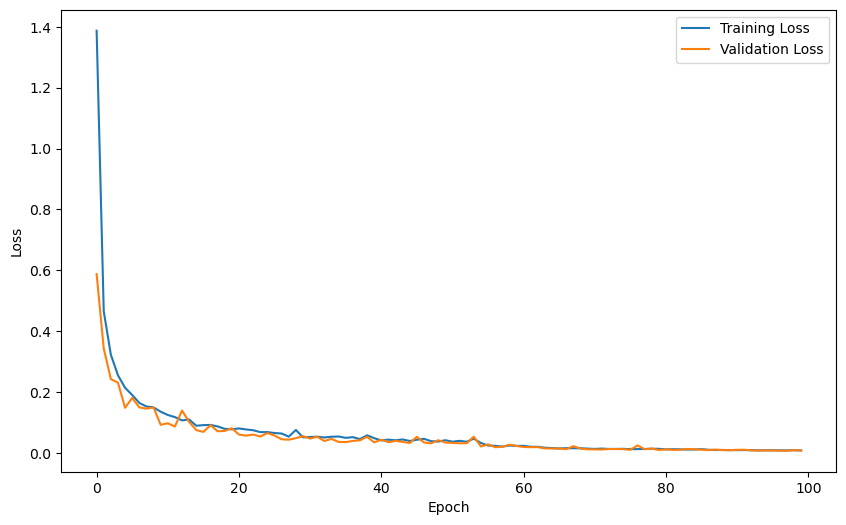

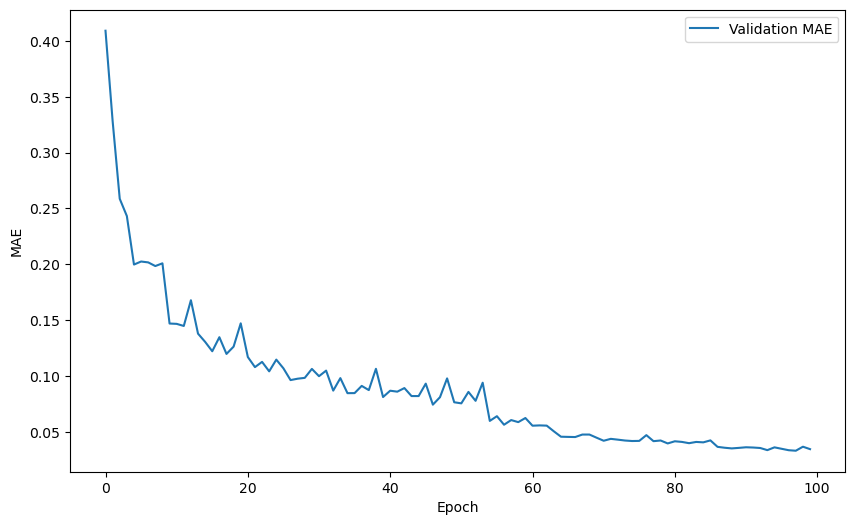

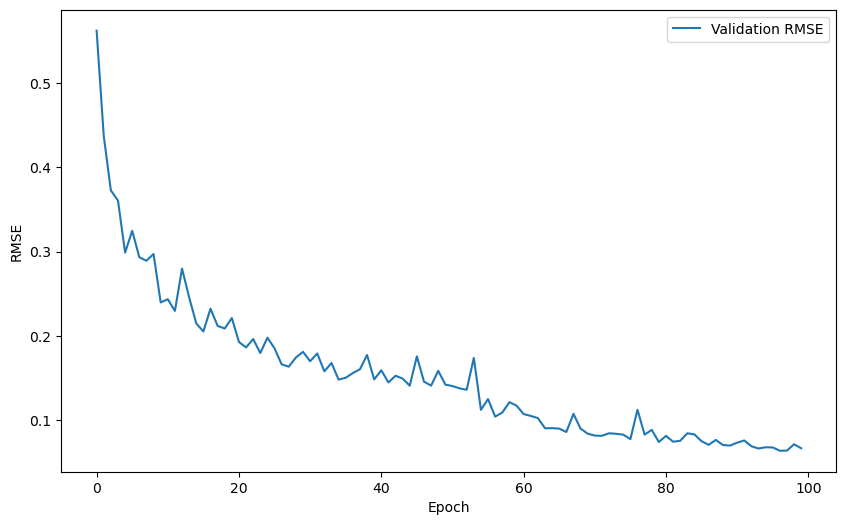

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(valid_mae, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(valid_rmse, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()


# Save the model

In [21]:
torch.save(model.state_dict(), 'CustomLoss_model5.pth')
print("Model saved as 'model.pth'")


Model saved as 'model.pth'
